In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn import tree

# you probably need to do `conda install graphviz` or `pip install graphviz`
import graphviz

%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

# Seed random functions for reproducibility
#np.random.seed(12345)

# Decision Trees

#### Objectives: Answer the following
 * When splitting a data set, how do you evaluate the quality of a split?
   * entropy, Gini impurity, and information gain
   * classification vs regression
 * How do you build a decision tree?
   * recursion
 * How can you tune a decision tree to prevent overfitting?
   * pruning

# "Play Tennis" data set

In [2]:
# Read in our data
tennis_df = pd.read_table('data/tennis.txt', delim_whitespace=True)

In [3]:
# Clean up a few things, based on my preferences and making calculating probabilities easier
tennis_df.rename(columns={'playtennis': 'played'}, inplace=True)
tennis_df['played'] = tennis_df['played'].apply(lambda x: 1 if x == 'yes' else 0)

In [4]:
# Let's look at the data
tennis_df.sort_values('played')

,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
13,rainy,mild,high,True,0
2,overcast,hot,high,False,1
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
6,overcast,cool,normal,True,1
8,sunny,cool,normal,False,1


## How Would You Determine If You Played Tennis?

Class discussion

## Quantifying Our Decisions

Does windiness do a good job of predicting "played"? Let's split our dataset into two subsets: points with `wind == True` and points with `wind == False`

In [5]:
mask = tennis_df['wind'] == True
print(tennis_df[mask])
print('-'*50)
print(tennis_df[~mask])

     outlook temperature humidity  wind  played
1      sunny         hot     high  True       0
5      rainy        cool   normal  True       0
6   overcast        cool   normal  True       1
10     sunny        mild   normal  True       1
11  overcast        mild     high  True       1
13     rainy        mild     high  True       0
--------------------------------------------------
     outlook temperature humidity   wind  played
0      sunny         hot     high  False       0
2   overcast         hot     high  False       1
3      rainy        mild     high  False       1
4      rainy        cool   normal  False       1
7      sunny        mild     high  False       0
8      sunny        cool   normal  False       1
9      rainy        mild   normal  False       1
12  overcast         hot   normal  False       1


How much did this help us? A perfect decision would have separated all the `played == 0` points from the `played == 1` points, and a perfectly useless decision would have given us two subsets of the data that each had equal amounts of `0`s and `1`s. Let's look at some possible metrics for quantifying how "mixed up" or "impure" a set of labels is.

### Shannon Entropy

One common measure of impurity is _entropy_ (there are other measures, but let's check this one out first). Let $Y$ be a discrete random variable with probability mass function $P(Y)$.

For today's purposes, the values of $Y$ are _class labels_, and $P(Y=j)=p_j$ is the _probability of drawing a point with class $j$_

For $m$ classes, the entropy is defined as:
$$\begin{align}
H(Y) & = E[log_2(\tfrac{1}{P(Y)})] \\
     & = -E[log_2(P(Y))] \\
     & = - \sum_{j=1}^m p_j log_2(p_j)
\end{align}
$$

### Entropy Graph of Bernoulli Random Variable
Say we have a set of labeled data $S = \{y_1, y_2, y_3, \ldots, y_n\}$, where each label $y_i$ is either positive ($+$) or negative ($-$). Let $p(+)$ be the probability of drawing a data point from $S$ with the positive label.

<img src="images/entropy_graph.png" width=500 align="left"/>

In [6]:
def calc_entropy(y):
    """Return the entropy of the array y.
    
    Parameters
    ----------
    y: 1d numpy array
    
    Returns
    -------
    float
    """
    summation = 0
    
    for class_i in np.unique(y):
        prob = np.mean(y == class_i)
        summation += prob * np.log2(prob)
    
    return -summation

In [7]:
y = tennis_df['played'].values
y1 = tennis_df.loc[mask, 'played'].values
y2 = tennis_df.loc[~mask, 'played'].values

print('labels from all data: ', y)
print('labels of windy data: ', y1)
print('labels of non-windy data: ', y2)

labels from all data:  [0 0 1 1 1 0 1 0 1 1 1 1 1 0]
labels of windy data:  [0 0 1 1 1 0]
labels of non-windy data:  [0 1 1 1 0 1 1 1]


In [8]:
print("Entropy of original data set: {:.4}".format(calc_entropy(y)))
print("Entropy of windy data: {:.4}".format(calc_entropy(y1)))
print("Entropy of non windy data: {:.4}".format(calc_entropy(y2)))

Entropy of original data set: 0.9403
Entropy of windy data: 1.0
Entropy of non windy data: 0.8113


### Information Gain 
The information gained from splitting a data set (parent node) into two subsets (child nodes) is defined as follows: the difference between the _impurity of the parent node $S$_ and the _sum of weighted impurities of the child nodes $\{C_i\}$_. A higher IG for a split means that the split did a better job of separating (or un-mixing) the class labels. 

$$\text{IG}(S, \{C_1, C_2, \ldots, C_k\}) = H(S) - \sum_{i=1}^k \frac{|C_i|}{|S|} H(C_i)$$


In [9]:
def calc_info_gain(y, y1, y2, impurity_func):
    """Return the information gain of making the given split.
    
    Parameters
    ----------
    y: 1d numpy array
        Labels for parent node
    
    y1: 1d numpy array
        Labels for potential child node 1
    
    y2: 1d numpy array
        Labels for potential child node 2
    
    impurity_func: function
        Function which calculates the impurity of the node 
        (e.g. Shannon Entropy)
    
    Returns
    -------
    float
    """
    total_samples = float(y.shape[0])
    child_imp = 0
    y_impurity = impurity_func(y)
    
    for child_node in (y1, y2):
        child_num = child_node.shape[0]
        child_imp += (child_num / total_samples) * impurity_func(child_node)
        
    return y_impurity - child_imp

In [10]:
# Information gain from splitting on wind
print("Information Gain is {0}.".format(calc_info_gain(y, y1, y2, calc_entropy)))

Information Gain is 0.04812703040826927.


What if we try splitting on "temperature == hot"?

In [11]:
y1 = tennis_df.loc[tennis_df['temperature'] == 'hot','played'].values
y2 = tennis_df.loc[tennis_df['temperature'] != 'hot','played'].values

In [12]:
print('labels from all data: ', y)
print('labels of hot data: ', y1)
print('labels of non-hot data: ', y2)

labels from all data:  [0 0 1 1 1 0 1 0 1 1 1 1 1 0]
labels of hot data:  [0 0 1 1]
labels of non-hot data:  [1 1 0 1 0 1 1 1 1 0]


In [13]:
print("Information Gain is {0}.".format(calc_info_gain(y, y1, y2, calc_entropy)))

Information Gain is 0.0250781735058504.


That's a lower information gain, so we can say that splitting the data on `temperature == hot` is worse than splitting the data on `windy == true`.

So what's the best splitting decision we could make? Let's try 'em all and see what has the highest information gain.

In [14]:
def calc_ig_for_all_splits(X, y):
    possible_splits = {}
    # Get just my features names
    feature_cols = X.columns

    # For a given column, find all the unique possible values
    for col in feature_cols:
        col_splits = np.unique(X[col])
        # For each possible value, split the dataset using that value
        for pos_val in col_splits:
            y1 = y.loc[X[col] == pos_val].values
            y2 = y.loc[X[col] != pos_val].values
            # Calculate the information gain, save it for later
            ig = calc_info_gain(y, y1, y2, calc_entropy)
            key = "{0}: {1}".format(col, pos_val)
            possible_splits[key] = ig
    return possible_splits

def display_split_results(possible_splits):
    # Print out our results in a pretty way
    colname1 = "Col Name: Value"
    colname2 = "Information Gain"

    # :20 is specifying a column width, https://docs.python.org/3/library/string.html#formatspec
    print("{0:20} || {1}".format(colname1, colname2))
    print("-----------------------------------------")
    for k,v in sorted(possible_splits.items(), key=lambda x: x[1], reverse=True):
        print("{0:20} || {1}".format(k, v))    

In [15]:
X = tennis_df.drop('played', axis = 1)
y = tennis_df['played']

possible_splits = calc_ig_for_all_splits(X,y)
display_split_results(possible_splits)

Col Name: Value      || Information Gain
-----------------------------------------
outlook: overcast    || 0.22600024438491662
humidity: high       || 0.15183550136234136
humidity: normal     || 0.15183550136234136
outlook: sunny       || 0.10224356360985054
wind: False          || 0.04812703040826927
wind: True           || 0.04812703040826927
temperature: hot     || 0.0250781735058504
temperature: cool    || 0.014956069928972582
outlook: rainy       || 0.003184853044648772
temperature: mild    || 0.0013397424044412354


Splitting on overcast gave us the largest info gain. Let's look at what those child nodes look like and their respective entropies.

In [16]:
child_node_left = tennis_df[tennis_df['outlook'] == 'overcast']
print("Entropy of left child node is {0}".format(
          calc_entropy(child_node_left['played'].values)))
child_node_left

Entropy of left child node is -0.0


,outlook,temperature,humidity,wind,played
2,overcast,hot,high,False,1
6,overcast,cool,normal,True,1
11,overcast,mild,high,True,1
12,overcast,hot,normal,False,1


In [17]:
child_node_right = tennis_df[tennis_df['outlook'] != 'overcast']
print("Entropy of right child node is {0}".format(
          calc_entropy(child_node_right['played'].values)))
child_node_right

Entropy of right child node is 1.0


,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
8,sunny,cool,normal,False,1
9,rainy,mild,normal,False,1
10,sunny,mild,normal,True,1
13,rainy,mild,high,True,0


So we made a splitting decision that divided the data into two subsets: one that had all the same label (a _pure node_) and another that was perfectly mixed: five $0$s and five $1$s. That's a little frustrating. What can we do?

Well lets's see if there's a splitting decision we can make for this second subset of data (the `outlook != overcast` data) to sort out the labels better.

In [18]:
mask = tennis_df['outlook'] != 'overcast'

possible_splits = calc_ig_for_all_splits(X[mask],y[mask])
display_split_results(possible_splits)

Col Name: Value      || Information Gain
-----------------------------------------
humidity: high       || 0.2780719051126377
humidity: normal     || 0.2780719051126377
temperature: hot     || 0.23645279766002802
wind: False          || 0.12451124978365313
wind: True           || 0.12451124978365313
temperature: cool    || 0.034851554559677034
outlook: rainy       || 0.02904940554533142
outlook: sunny       || 0.02904940554533142
temperature: mild    || 0.02904940554533142


In [19]:
child_node_left = tennis_df[mask & (tennis_df['humidity'] == 'high')]
print("Entropy of left child node is {0}".format(
          calc_entropy(child_node_left['played'].values)))
child_node_left

Entropy of left child node is 0.7219280948873623


,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
3,rainy,mild,high,False,1
7,sunny,mild,high,False,0
13,rainy,mild,high,True,0


In [20]:
child_node_right = tennis_df[mask & (tennis_df['humidity'] != 'high')]
print("Entropy of right child node is {0}".format(
          calc_entropy(child_node_right['played'].values)))
child_node_right

Entropy of right child node is 0.7219280948873623


,outlook,temperature,humidity,wind,played
4,rainy,cool,normal,False,1
5,rainy,cool,normal,True,0
8,sunny,cool,normal,False,1
9,rainy,mild,normal,False,1
10,sunny,mild,normal,True,1


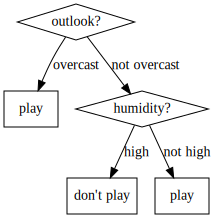

In [21]:
from graphviz import Digraph
dot = Digraph(comment='A simple classification tree')

dot.node('O', 'outlook?', shape='diamond')
dot.node('1', "play", shape='rectangle')
dot.node('H', 'humidity?', shape='diamond')

dot.node('2', "don't play", shape='rectangle')
dot.node('3', 'play', shape='rectangle')

dot.edge('O', '1', 'overcast')
dot.edge('O', 'H', 'not overcast')
dot.edge('H', '2', 'high')
dot.edge('H', '3', 'not high')

dot

#### exercise

Using this tree, what would we predict for a day with `outlook == overcast` and `humidity == normal`?

How about `outlook == sunny` and `humidity == high`?

In [22]:
# sklearn's implementation requires
# numerical features and only makes
# binary splits

X_dum = pd.get_dummies(X)

dt = tree.DecisionTreeClassifier(max_depth=2, criterion='entropy')
dt.fit(X_dum, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

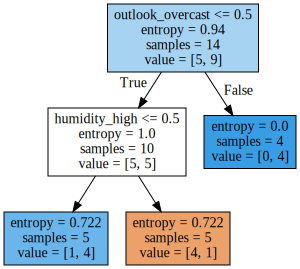

In [23]:
graphviz.Source(tree.export_graphviz(dt, out_file=None, 
                                     feature_names=X_dum.columns,
                                     filled=True))

### When do we stop?

We've made two decisions that almost completely sort out "played" from "not played"

Almost completely.. we could find splits that completely sort out these sets too, couldn't we?

In [24]:
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt.fit(X_dum, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

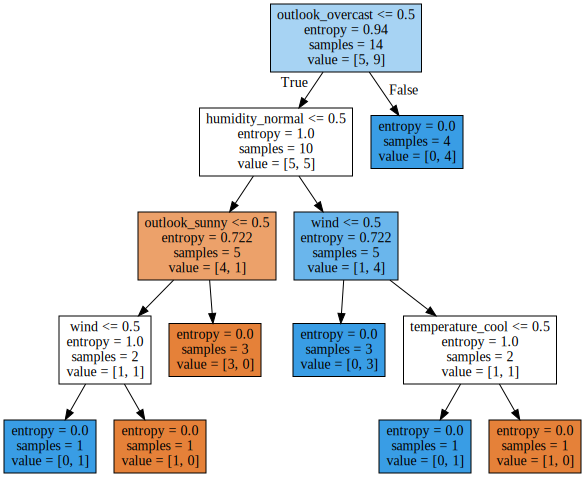

In [25]:
graphviz.Source(tree.export_graphviz(dt, out_file=None, 
                                     feature_names=X_dum.columns,
                                     filled=True))

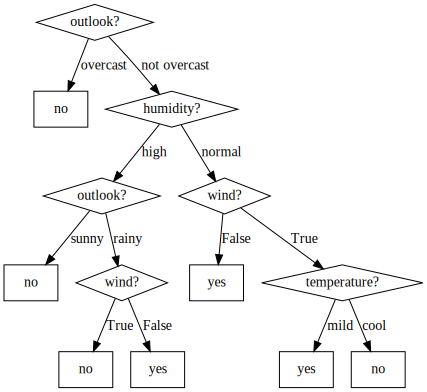

In [26]:
dot = Digraph(comment='A simple classification tree')

dot.node('O', 'outlook?', shape='diamond')
dot.node('1', "no", shape='rectangle')
dot.node('H', 'humidity?', shape='diamond')
dot.node('O2', 'outlook?', shape='diamond')
dot.node('W', 'wind?', shape='diamond')
dot.node('3', 'yes', shape='rectangle')
dot.node('T', 'temperature?', shape='diamond')
dot.node('4', 'yes', shape='rectangle')
dot.node('5', "no", shape='rectangle')
dot.node('2', "no", shape='rectangle')
dot.node('W2', 'wind?', shape='diamond')
dot.node('6', "no", shape='rectangle')
dot.node('7', 'yes', shape='rectangle')

dot.edge('O', '1', 'overcast')
dot.edge('O', 'H', 'not overcast')
dot.edge('H', 'O2', 'high')
dot.edge('H', 'W', 'normal')
dot.edge('W', '3', 'False')
dot.edge('W', 'T', 'True')
dot.edge('T', '4', 'mild')
dot.edge('T', '5', 'cool')
dot.edge('O2', '2', 'sunny')
dot.edge('O2', 'W2', 'rainy')
dot.edge('W2', '7', 'False')
dot.edge('W2', '6', 'True')
dot

### Decision Tree Vocabulary
Each subset of data is called a ***node***. The full set of data is called the ***root node***. Each decision is a ***split*** based on some ***split criterion*** that divides a ***parent node*** into ***child nodes***. A node with data from only one class is called a ***pure node***, and a node with no children is called a ***leaf node***.

## Other Ways to Calculate Impurity

### Gini Impurity

This is the default for sci-kit learn trees. Again it involves knowing the class frequencies $p_i$ within a set of points.

The Gini impurity is the _probability of misclassification_ under the following procedure:
* Take a random element from the set.
* Label it randomly according to the distribution of labels in the set.

The probability of picking a point of class $i$ is $p_i$, and the probability of then giving it the wrong label is $(1-p_i)$, so the total misclassification probability for a set containing $m$ classes is

$$\text{Gini}(S) = \sum_{i=1}^m p_i(1-p_i) = 1 - \sum_{i=1}^m p_i^2$$

### Information Gain with Gini Impurity

$$\text{IG}(S, C) = \text{Gini}(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} \text{Gini}(C_i)$$

## Regression Trees

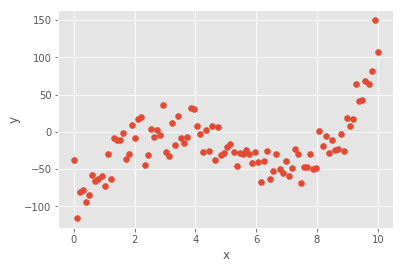

In [27]:
x_r = np.linspace(0,10,100).reshape(-1,1)
y_r = (x_r - 4)**3 - 5*((x_r -3)**2) + np.exp((x_r - 5))
y_r = y_r + 20*np.random.normal(0,1, size=y_r.shape)

plt.scatter(x_r, y_r)
plt.xlabel('x')
plt.ylabel('y');

### What if your target $y$ is numerical instead of categorical?

For a classification tree, the predicted label is simply the majority class (mode) of the data in the given node. How does prediction work in a regression tree?

Information gain, entropy, and Gini impurity are only defined for sets of discrete class labels (and we defined them because we wanted a way to measure how "mixed up" a set of class labels is). If we have a set of *numbers* instead, what is an analogous measure for how "mixed up" the values are?

Variance! For a node $S$ with $N$ data points:
$$ \text{Var}(S) = \frac{1}{N}\sum_{i=1}^N (y_i - \bar{y})^2$$
$$ \bar{y} = \frac{1}{N}\sum_{i=1}^N y_i $$

$$\text{reduction_of_variance}(S, C) = \text{Var}(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} \text{Var}(C_i)$$


Sometimes you'll see this expression written in terms of the *total sum of squared errors (SSE)* of each node instead of the *variance* (the mean squared error):
$$ \begin{align} \text{reduction_of_variance} & = \frac{1}{|S|}\left(\sum_{i \in S} (y_i - \bar{y_S})^2\right) - \left(\frac{|C_L|}{|S|}\frac{1}{|C_L|}\sum_{i \in C_L} (y_i - \bar{y_L})^2 + \frac{|C_R|}{|S|}\frac{1}{|C_R|}\sum_{i\in C_R} (y_i - \bar{y_R})^2\right) \\
 & = \frac{1}{|S|}\left[\left(\sum_{i \in S} (y_i - \bar{y_S})^2\right) - \left(\sum_{i \in C_L} (y_i - \bar{y_L})^2 + \sum_{i\in C_R} (y_i - \bar{y_R})^2\right)\right]
 \\ & = \frac{1}{|S|} \left[\text{SSE}_S - \text{SSE}_{C_L} - \text{SSE}_{C_R} \right] \end{align}$$


#### example

 $x_1$ |   $x_2$ |  $y$
-------|---------|--------
 1     |    1    |   1
 0     |    0    |   2
 1     |    0    |   3
 0     |    1    |   4

 Prior to the split we guess the mean, 2.5, for everything, giving total squared error:
 
 $$ E = (1-2.5)^2 + (2-2.5)^2 + (3-2.5)^2 + (4-2.5)^2  = 5$$
 After we split on $x_1$ we guess 2 for rows 1 & 3 and 3 for rows 2 & 4:
 
 $$ I = 5 - [(1-2)^2 + (3-2)^2 + (2-3)^2 + (4-3)^2] = 5 - 4  = 1 $$

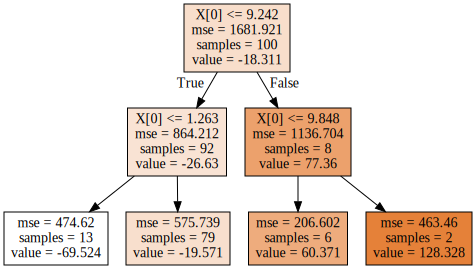

In [28]:
dt_r = tree.DecisionTreeRegressor(max_depth=2)
dt_r.fit(x_r, y_r)


graphviz.Source(tree.export_graphviz(dt_r, out_file=None,
                                     filled=True))

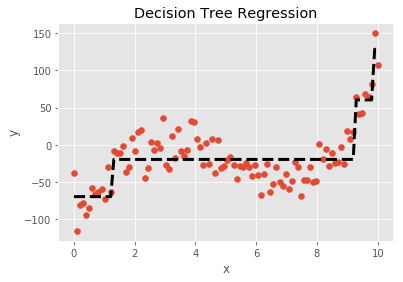

In [29]:
plt.scatter(x_r, y_r)
plt.plot(x_r, dt_r.predict(x_r),
         'k--', linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Decision Tree Regression");

## Predicting

The final predictions of a decision tree and a regression tree are implemented differently:

### Classification

* Majority class in leaf node
* Better to output the class frequency for every class (that is, label probability if you were drawing data only from that node).

### Regression

* Mean of values in leaf node
* Or fit a line to all the values in a leaf node, so you have a linear regression model for each leaf
    * Also called *model trees*

## Building a decision tree with recursion

Let's review the process of building a decision tree:
- find the feature & value that best splits your data into two subsets (nodes), where "best" is measured by information gain
- then, for each node, find the feature & value that best splits that node into two more nodes
 - if a node is pure, then it doesn't need to be split
- then, for each of those nodes, find the feature & value that best splits that node into two more ...
- stop when all your nodes are pure (we'll consider other stopping criteria later)

How would we write code to do this? It seems like the main work will be done by one function, `find_best_feature_and_value_to_split_on(X, y)`. First we'll call it on the entire data set, then we'll call it on each child node, then each child node's children, etc., making sure not to call it on a pure node. 

We can write this as a ***recursive*** function: a function that calls itself. A recursive function must have two cases, and which case is executed depends on the input:
- a base case, where the function does not call itself. this is the stopping criterion for execution. an ill-defined base case will result in an infinite loop
- a recursive case, where the function somehow splits or reduces its input and calls itself on the split / reduced input. The recursive case will be called again and again until the base case is reached.

### DT Pseudocode

Recursive partitioning algorithm

```
function build_tree(data):
    # base case, stop building tree
    If every item in the dataset is in the same class (or if every split has zero information gain):
        return a leaf node with the class label (or the majority class label)
        
    # recursive case, keep splitting stuff
    Else:
        find the best feature and value to split the data
        split the dataset into two subsets, c1 and c2
        create a node
        set c1 and c2 as the child nodes
        node.left_child = build_tree(c1)
        node.right_child = build_tree(c2)
        return node
```
Then `build_tree(full_data_set)` will return the root node of the tree (which, through its children and grandchildren, contains the entire tree).

## Recursion practice 

Recursion uses the idea of "divide and conquer" to solve problems. It divides a complex problem you are working on into smaller sub-problems that are easily solved, rather than trying to solve the complex problem directly.

### Three Laws of Recursion

1. A recursive algorithm must have a base case.
2. A recursive algorithm must change its state and move toward the base case.
3. A recursive algorithm must call itself, recursively.
    
### Example: Factorial

$$ f(x) = \prod_{i=1}^xi $$

$$f(x) =
\left\{
	\begin{array}{ll}
		1  & \mbox{if } x \leq 1 \\
		xf(x-1) & \mbox otherwise
	\end{array}
\right.
$$

In [30]:
def factorial(x):
    """Recursively calculate x!"""
    # base case is when we get to x=0, which is 0! = 1
    if x == 0:
        return 1
    # otherwise, recursive case, notice how we are reducing x
    else:
        return x * factorial(x-1)

In [31]:
factorial(25)

15511210043330985984000000

In [32]:
factorial(200)

788657867364790503552363213932185062295135977687173263294742533244359449963403342920304284011984623904177212138919638830257642790242637105061926624952829931113462857270763317237396988943922445621451664240254033291864131227428294853277524242407573903240321257405579568660226031904170324062351700858796178922222789623703897374720000000000000000000000000000000000000000000000000

In [33]:
def power(base, exp):
    """Recursively caclulate base ** exp"""
    # base case is when exp = 0, base ** 0 = 1
    if exp == 0:
        return 1
    #  otherwise, recursive case, reduce exp
    return base * power(base, exp - 1)

In [34]:
power(2, 6)

64

In [35]:
%%timeit -n 20
power(25, 5)

880 ns ± 47.1 ns per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [36]:
%%timeit -n 20
25 ** 5

18.8 ns ± 6.64 ns per loop (mean ± std. dev. of 7 runs, 20 loops each)


Recursion not always the answer, but useful tool to have.

### You do, fill in the following function

In [37]:
def len_str(s):
    """Recursively determine the length of a string"""
    # base case, when should you stop?

    # recursive case, how can you reduce your problem?


In [38]:
#test your function
len_str('pineapple')

## Performance of Decision Trees

Class discussion: what are some problems you forsee with this approach?

http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

Let's go back to the dogs and horses.

In [39]:
def make_horse_dog_data(n_horses, n_dogs, messiness=1):
    """Return sample of horse dog data
    
    Parameters
    ----------
    n_horses: int
        The number of horses
    n_dogs: numpy array
        The number of dogs
    messiness: float
        How much to multiple by the standard deviations of the logs (default 1)
        
    Returns
    -------
    horse_weight: numpy array
        The weights of the horses
    horse_height: numpy array
        The height of the horses
    dog_weight: numpy array
        The weight of the dogs
    dog_height: numpy array
        The height of the dogs
    """

    horse_weight = scs.norm(3,0.15*messiness).rvs(n_horses)
    horse_height = horse_weight * 0.4 + scs.norm(-0.5,0.05*messiness).rvs(n_horses)
    horse_weight = 10**horse_weight
    horse_height = 10**horse_height
    dog_weight = np.zeros(n_dogs)
    dog_height = np.zeros(n_dogs)

    dog_weight[:n_dogs//2] = scs.norm(1.7,0.20*messiness).rvs(n_dogs//2)
    dog_weight[n_dogs//2:] = scs.norm(2.5,0.25*messiness).rvs(n_dogs//2)
    dog_height[:n_dogs//2] = dog_weight[:n_dogs//2]*0.50 + scs.norm(-0.5,0.2*messiness).rvs(n_dogs//2)
    dog_height[n_dogs//2:] = dog_weight[n_dogs//2:]*0.30 + scs.norm(-0.5,0.1*messiness).rvs(n_dogs//2)
    dog_weight = 10**dog_weight
    dog_height = 10**dog_height
    return horse_weight, horse_height, dog_weight, dog_height


def prep_data_for_model(horse_weight, horse_height, dog_weight, dog_height):
    """Return horse dog data in format for kNN classification.
    
    Parameters
    ----------
    horse_weight: numpy array
        The weights of the horses
    horse_height: numpy array
        The height of the horses
    dog_weight: numpy array
        The weight of the dogs
    dog_height: numpy array
        The height of the dogs
        
    Returns
    -------
    X: numpy array, shape = [n_samples, 2]
        The features (weight, height) of the data
    y: numpy array, shape = [n_samples,]
        The labels for our classification (horse=0, dog=1)
    """
    X = np.column_stack((np.concatenate((horse_weight, dog_weight)),
                         np.concatenate((horse_height, dog_height))))
    y = np.concatenate((np.zeros(horse_weight.shape),
                        np.ones(dog_weight.shape)))
    return X, y

# Function to make getting new samples for model input easier, laziness always wins
def get_new_ugly_sample():
    """Return new sample ready for modeling.
    
    Combines make_ugly_data and prep_data_for_model, see the docs for those functions
    """
    horse_weight, horse_height, dog_weight, dog_height = make_horse_dog_data(100, 60, messiness=1.5)
    X, y = prep_data_for_model(horse_weight, horse_height, dog_weight, dog_height)
    return X, y


def plot_classification_tree(ax, X, y, model=None):
    """Plot the horse dog data"""
    ax.plot(X[y==0, 0], X[y==0, 1], 'r.', label='Horse')
    ax.plot(X[y==1, 0], X[y==1, 1], 'b.', label='Dog')
    ax.set_title("Classifying Horses and Dogs with Decision Trees")
    ax.set_xlabel("Weight (lbs)")
    ax.set_ylabel("Height (ft)")
    ax.legend(loc='upper left')
    
    if model is None:
        model = tree.DecisionTreeClassifier()
    model.fit(X, y)
    # preserve upper limits
    xlim = (0, ax.get_xlim()[1])
    ylim = (0, ax.get_ylim()[1])
    plot_classification_thresholds(ax, X, y, 0, model.tree_, xlim, ylim)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def plot_classification_thresholds(ax, X, y, inode, tree, xlim, ylim):
    threshold = tree.threshold[inode]
    if tree.feature[inode] == -2:
        color = ['r', 'b'][np.argmax(tree.value[inode])]
        ax.add_patch(Rectangle((xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], fc=color, alpha=0.3))
        return
    if tree.feature[inode] == 0:
        ax.plot((threshold, threshold), ylim, 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, (xlim[0], threshold), ylim)
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, (threshold, xlim[1]), ylim)
    else:
        ax.plot(xlim, (threshold, threshold), 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, xlim, (ylim[0], threshold))
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, xlim, (threshold, ylim[1]))        


In [40]:
X, y = get_new_ugly_sample()

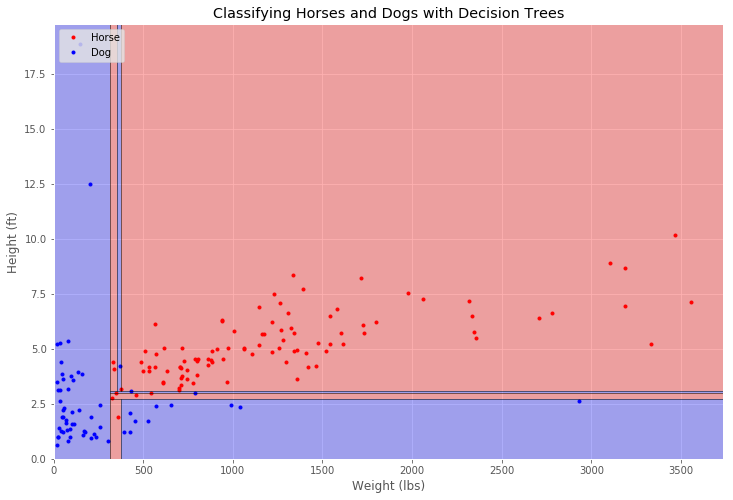

In [41]:
model = tree.DecisionTreeClassifier()
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y, model)

Clearly there is some risk of overfitting.

## Combatting overfitting: Pruning

We call the idea of modifying a decision tree to improve its test-set performance ***pruning***.

There are two approaches: ***pre-pruning*** and ***post-pruning***.

### Pre-pruning
- minimum leaf size: don't split a node if it has min_leaf_size samples or fewer
- maximum tree depth: limit the maximum number of successive splits (for example, if the max_depth is 2, the root node can have grandchildren but not great-grandchildren).
- maximum purity: if the purity of a node is above a certain threshold, don't bother splitting it
- gain threshold: if the information gain (or reduction in variance, for a regression three) is below a certain threshold, don't bother with the split

In [42]:
with open('answers/preprune.txt') as f:
    for line in f:
        print(line)

Common Things to Pre-Prune

--------------------------

* Leaf size: stop splitting when num of samples is small enough

* Tree depth: stop splitting at a certain depth

* Purity: stop splitting if purity of leaf nodes hits certain threshold

* Gain Threshold: stop splitting when info gain fails to meet threshold



### Post-pruning

Build a complete, overfit tree full of pure leaf nodes that only have one or two samples each. Then merge leaf nodes if doing so decreases test-set error

#### Pseudocode
```
function Prune:
    if either left or right is not a leaf:
        call Prune on those that aren't
    if both left and right are (now) leaf nodes:
        calculate error associated with merging two leaf nodes
        calculate error associated without merging two leaf nodes
        if merging results in lower error:
            merge the leaf nodes
```

## Picking the Best Tree

* Cross validate!
    * Train trees with different hyperparameters, see which performs best on validation set
    * No different than any other model

## Decision Tree Summary

What are the pros and cons?

Pros
 * No feature scaling needed
 * Model nonlinear relationships
 * Can do both classification and regression
 * Robust
 * Highly interpretable

Cons
 * Can be expensive to train
 * Need to be tuned so they don't totally overfit


## The Decision Tree Algorithms

There are some famous variants of the decision tree algorithm:

### ID3

Short for Iterative Dichotomiser 3, the original Decision Tree algorithm developed by Ross Quinlan (who's responsible for a lot of proprietary decision tree algorithms) in the 1980's.

* designed for only categorial features
* splits categorical features completely
* uses entropy and information gain to pick the best split

### CART

Short for Classification and Regression Tree was invented about the same time as ID3 by Breiman, Friedman, Olshen and Stone. The CART algorithm has the following properties:

* handles both categorial and continuous data
* always uses binary splits
* uses gini impurity to pick the best split

Algorithms will be called CART even if they don't follow all of the specifications of the original algorithm.

### C4.5

This is Quinlan's first improvement on the ID3 algorithm. The main improvements are:

* handles continuous data
* implements pruning to reduce overfitting

### C5.0

This is supposedly better, but it's proprietary so we don't have access to the specifics of the improvements.